<a href="https://colab.research.google.com/github/thamyrissacamoto/MarvelAPI/blob/dev/AnalisandoInsights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !unzip "./TodosComics2.zip" -d "./"

# IMPORTS

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import ast

In [3]:
comics = pd.read_csv("TodosComics.csv")
characters = pd.read_csv("TodosPersonagens.csv")
creators = pd.read_csv("TodosCreators.csv")
events = pd.read_csv("TodosEvents.csv")
series = pd.read_csv("TodosSeries.csv")
creators_rel_events = pd.read_csv("creators_ids_events.csv")
characters_rel = pd.read_csv("characters_ids_relationships.csv")

# FUNCTIONS

In [4]:
def categorize_duration(years):
    if years > 25:
        return "Durou mais que 25 anos"
    elif years >= 15 and years <= 25:
        return "Durou entre 15 e 25 anos"
    elif years < 15 and years >= 5:
        return "Durou entre 5 e 14 anos"
    else:
        return "Durou menos que 5 anos"

In [5]:
def get_onsale_year(date_str):
    try:
        date_list = ast.literal_eval(date_str)
        for d in date_list:
            if d['type'] == 'onsaleDate':
                return d['date'][:4]  # Return only the year part
    except (ValueError, SyntaxError, TypeError):
        return None  # If it fails, return None

In [6]:
events = events[~events["start"].isna()]

events.loc[:, "Ano_Inicio"] = events["start"].str.split('-').str[0].astype(int)
events.loc[:, "Ano_Final"] = events["end"].str.split('-').str[0].astype(int)
events = events[events["Ano_Final"] <= 2025]

events.loc[:, "duracao"] = events["end"].str.split('-').str[0].astype(int) - events["start"].str.split('-').str[0].astype(int)

events.loc[:, "categoria_duracao"] = events["duracao"].apply(categorize_duration)

<ipython-input-6-02634661ea79>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events.loc[:, "Ano_Inicio"] = events["start"].str.split('-').str[0].astype(int)
<ipython-input-6-02634661ea79>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events.loc[:, "Ano_Final"] = events["end"].str.split('-').str[0].astype(int)


# INSIGHTS

## Verificando Integridade da base de dados

In [7]:
Nan_relation = {}
for col in comics.columns:
    Nan_relation[col] = comics[col].isna().sum()

df = pd.DataFrame(list(Nan_relation.items()), columns=['Colunas', 'Quantidade'])

df["Quantidade"] = pd.to_numeric(df["Quantidade"], errors="coerce")

df = df[df["Quantidade"] > 0]

df = df.sort_values(by="Quantidade", ascending=False)

fig = px.bar(df, x='Colunas', y='Quantidade',
             color="Colunas",
             template="presentation",
             labels={'Colunas': 'Colunas', 'Quantidade': 'Frequência de Nulos'},
             title="Quantidade de valores nulos por coluna em Comics")

fig.update_layout(xaxis_tickangle=-15)
fig.show()


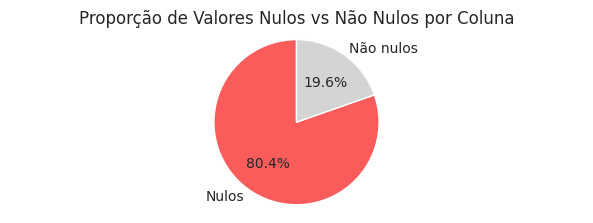

In [28]:
cols_with_nan = [col for col in characters.columns if characters[col].isna().sum() > 0]

n = len(cols_with_nan)
fig, axes = plt.subplots(nrows=(n + 1) // 2, ncols=2, figsize=(12, n * 2.5))
axes = axes.flatten()

for i, col in enumerate(cols_with_nan):
    total = len(characters)
    n_nulls = characters[col].isna().sum()
    n_non_nulls = total - n_nulls

    sizes = [n_nulls, n_non_nulls]
    labels = ['Nulos', 'Não nulos']
    colors = ['#fa5c5c','#d4d4d4']

    axes[i].pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        colors=colors,
        startangle=90,
        textprops={'fontsize': 10}
    )
    axes[i].axis('equal')
    axes[i].set_title(f'Proporção de Valores Nulos vs Não Nulos por Coluna')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [10]:
characters["last_modified"] = characters["modified"].str.split('-').str[0]
personagens_modificados = characters["last_modified"].value_counts().reset_index()
personagens_modificados.columns = ["Ano", "Quantidade"]

media = personagens_modificados["Quantidade"].mean()

personagens_modificados[personagens_modificados["Quantidade"] > media]


fig = px.bar(personagens_modificados, x='Ano', y='Quantidade',
             color="Ano",
             template="presentation",
             labels={'Colunas': 'Ano de Modificação', 'Quantidade': 'Quantidade de Modificações'},
             title="Quantidade de modificações por ano em Characters")

fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [10]:
comics["last_modified"] = comics["modified"].str.split('-').str[0]
comics_modificados = comics["last_modified"].value_counts().reset_index()
comics_modificados.columns = ["Ano", "Quantidade"]

media = abs(comics_modificados["Quantidade"].mean())

comics_modificados[comics_modificados["Quantidade"] > media]

fig = px.bar(comics_modificados, x='Ano', y='Quantidade',
             color="Ano",
             template="presentation",
             labels={'Colunas': 'Ano de Modificação', 'Quantidade': 'Quantidade de Modificações'},
             title="Quantidade de modificações por ano em Comics")

fig.update_layout(xaxis_tickangle=-45)
fig.show()

## POPULARIDADE DE PERSONAGENS

In [11]:
characters["total_aparicoes"] = characters[["comics.available", "series.available", "stories.available", "events.available"]].sum(axis=1)

df_top_total = characters.sort_values("total_aparicoes", ascending=False).head(10)

custom_colors = {
    "Spider-Man (Peter Parker)": "#F54242",
    "X-Men": "#FFDE69",
    "Iron Man": "#B30802",
    "Wolverine": "#FF9C38",
    "Captain America": "#455BD9",
    "Avengers": "#A460FC",
    "Thor": "#A6A6A6",
    "Hulk": "#046E00",
    "Fantastic Four": "#549CCC",
    "Daredevil": "#6E0000"
}

fig = px.bar(
    df_top_total,
    y="name",
    x="total_aparicoes",
    text="total_aparicoes",
    orientation="h",
    color="name",
    color_discrete_map=custom_colors,
    title="Top 10 Personagens por Total de Aparições",
    labels={"name": "Personagem", "total_aparicoes": "Total de Aparições"},
    template="plotly_white"
)

fig.update_traces(textposition="outside")
fig.update_layout(showlegend=False)
fig.show()


In [12]:
cols = ["comics.available", "series.available", "stories.available", "events.available"]
titles = {
    "comics.available": "Número de HQs",
    "series.available": "Número de Séries",
    "stories.available": "Número de Histórias",
    "events.available": "Número de Eventos"
}

custom_colors = {
    "Spider-Man (Peter Parker)": "#F54242",
    "X-Men": "#FFDE69",
    "Iron Man": "#B30802",
    "Wolverine": "#FF9C38",
    "Captain America": "#455BD9",
    "Avengers": "#A460FC",
    "Thor": "#A6A6A6",
    "Hulk": "#046E00",
    "Fantastic Four": "#549CCC",
    "Daredevil": "#6E0000"
}

df_top = characters[["name"] + cols].sort_values(by="comics.available", ascending=False).head(10)

for col in cols:
    df_sorted = df_top.sort_values(by=col, ascending=False)

    fig = px.bar(
        df_sorted,
        x="name",
        y=col,
        color="name",
        color_discrete_map=custom_colors,
        title=f"Top 10 Personagens - {titles[col]}",
        labels={col: "Quantidade", "name": "Personagem"},
        hover_data=["name", col],
    )
    fig.update_traces(textposition="outside")
    fig.update_layout(
        xaxis_tickangle=-45,
        yaxis=dict(gridcolor="lightgray"),
        template="plotly_white",
        height=500
    )
    fig.show()

## Quantidade de Histórias

In [13]:
comics['onsale_year'] = comics['dates'].apply(get_onsale_year)
comics['onsale_year'] = comics['onsale_year'].astype(int)
comics = comics[(comics['onsale_year'] >= 1940) & (comics['onsale_year'] <= 2025)]

comics['Preco'] = comics['prices'].apply(lambda x: ast.literal_eval(x)[0]['price'])

price_year = comics[["Preco", "onsale_year"]].rename(columns={"onsale_year": "Ano"})

comics = comics[~comics["id"].isna()]
comics["id"] = comics["id"].astype(int)

In [14]:
price_year.head()

,Preco,Ano
82,34.99,2025
83,125.00,2025
84,3.99,2025
85,3.99,2025
86,50.00,2025


In [15]:
preco_maior_zero = len(price_year[price_year["Preco"]>0])
media_historias = comics["stories.available"].mean()


print(f"Quantidade de linhas geral: {len(price_year)}")
print(f"Quantidade de linhas com preço acima de zero: {preco_maior_zero}")


comics = pd.concat([comics, price_year["Preco"]], axis=1)

media_precos = price_year.groupby("Ano")["Preco"].mean().reset_index()
media_precos_maior_zero = price_year[price_year["Preco"] > 0].groupby("Ano")["Preco"].mean().reset_index()

media_precos_maior_zero["Ano"] = media_precos_maior_zero["Ano"].astype(int)
media_precos_maior_zero["Preco"] = media_precos_maior_zero["Preco"].astype(int)

Quantidade de linhas geral: 63706
Quantidade de linhas com preço acima de zero: 39405


In [16]:
media_historias = comics["stories.available"].mean()
print(f"Média de histórias: {media_historias}")

len_maior_zero = len(comics[comics["stories.available"] > 0])
len_maior_media = len(comics[comics["stories.available"] > comics["stories.available"].mean()])

print(f"Quantidade de histórias (Maior que Zero): {len_maior_zero}")
print(f"Quantidade de histórias (Maior que Média): {len_maior_media}")

Média de histórias: 2.4966408187611844
Quantidade de histórias (Maior que Zero): 63694
Quantidade de histórias (Maior que Média): 10111


In [17]:
soma_historias_zero = comics[comics["stories.available"] > 0].groupby("onsale_year")["stories.available"].sum().reset_index()
soma_historias_media = comics[comics["stories.available"] > comics["stories.available"].mean()].groupby("onsale_year")["stories.available"].sum().reset_index()

soma_historias_zero["onsale_year"] = soma_historias_zero["onsale_year"].astype('category')
soma_historias_media["onsale_year"] = soma_historias_media["onsale_year"].astype('category')

soma_historias_zero["decade"] = (soma_historias_zero["onsale_year"].astype(int) // 10) * 10
soma_historias_media["decade"] = (soma_historias_media["onsale_year"].astype(int) // 10) * 10

soma_historias_zero["decade"] = soma_historias_zero["decade"].astype("category")
soma_historias_media["decade"] = soma_historias_media["decade"].astype("category")

soma_historias_zero_decade = soma_historias_zero.groupby("decade", as_index=False, observed=False)["stories.available"].mean()
soma_historias_media_decade = soma_historias_media.groupby("decade", as_index=False, observed=False)["stories.available"].mean()

soma_historias_zero["onsale_year"] = soma_historias_zero["onsale_year"].astype(int)
soma_historias_media["onsale_year"] = soma_historias_media["onsale_year"].astype(int)

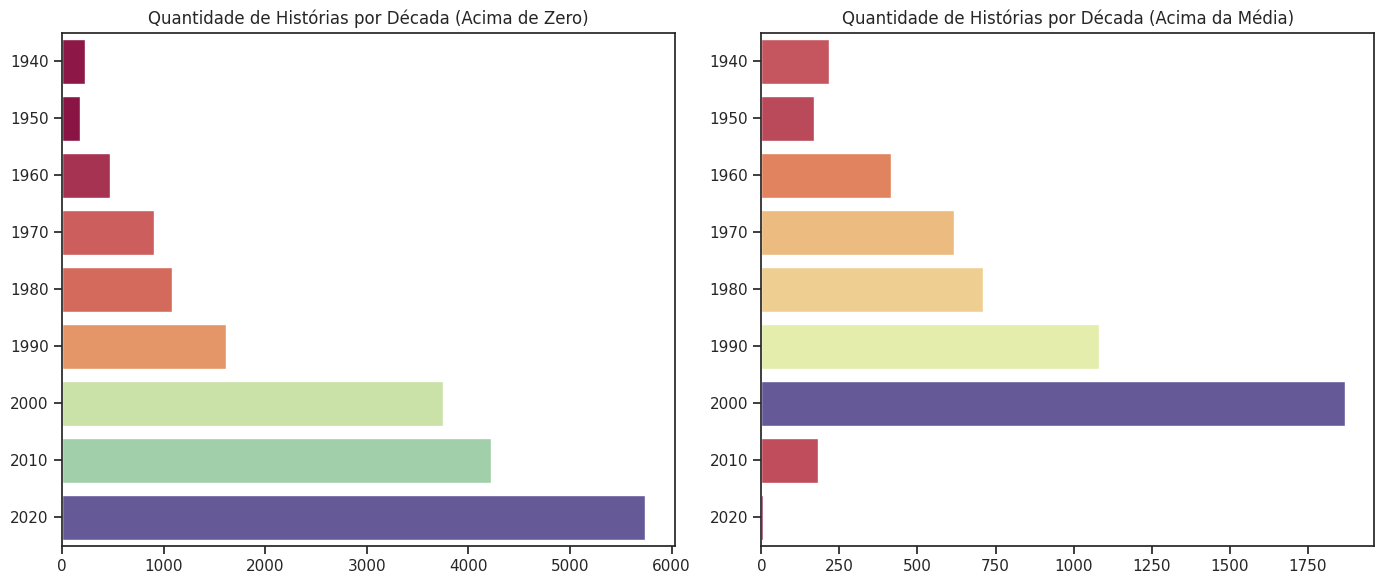

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

soma_historias_zero_decade_sorted = soma_historias_zero_decade.sort_values(by="stories.available", ascending=False)
sns.barplot(data=soma_historias_zero_decade, y='decade', x='stories.available', palette='Spectral', hue="stories.available", ax=axes[0])
axes[0].set_title("Quantidade de Histórias por Década (Acima de Zero)")
axes[0].legend_.remove()
axes[0].set_xlabel("")
axes[0].set_ylabel("")

sns.barplot(data=soma_historias_media_decade, y='decade', x='stories.available', palette='Spectral', hue="stories.available", ax=axes[1])
axes[1].set_title("Quantidade de Histórias por Década (Acima da Média)")
axes[1].legend_.remove()
axes[1].set_xlabel("")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

In [20]:
media_historias_zero = comics[comics["stories.available"] > 0].groupby("onsale_year")["stories.available"].mean().reset_index()
media_historias_media = comics[comics["stories.available"] > comics["stories.available"].mean()].groupby("onsale_year")["stories.available"].mean().reset_index()

media_historias_zero["onsale_year"] = media_historias_zero["onsale_year"].astype('category')
media_historias_media["onsale_year"] = media_historias_media["onsale_year"].astype('category')

media_historias_zero["decade"] = (media_historias_zero["onsale_year"].astype(int) // 10) * 10
media_historias_media["decade"] = (media_historias_media["onsale_year"].astype(int) // 10) * 10

media_historias_zero["decade"] = media_historias_zero["decade"].astype("category")
media_historias_media["decade"] = media_historias_media["decade"].astype("category")

media_historias_zero_decade = media_historias_zero.groupby("decade", as_index=False, observed=False)["stories.available"].mean()
media_historias_media_decade = media_historias_media.groupby("decade", as_index=False, observed=False)["stories.available"].mean()

media_historias_zero["onsale_year"] = media_historias_zero["onsale_year"].astype(int)
media_historias_media["onsale_year"] = media_historias_media["onsale_year"].astype(int)

<ipython-input-21-7c098802828f>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-21-7c098802828f>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




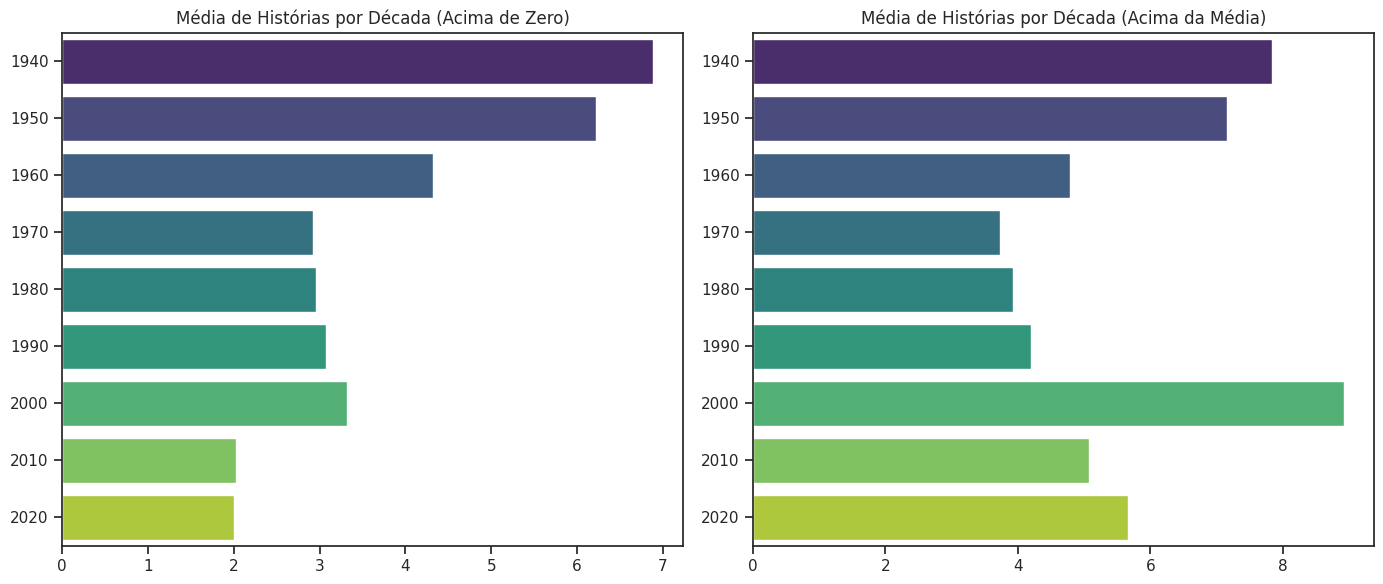

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(data=media_historias_zero_decade, y='decade', x='stories.available', palette='viridis' , ax=axes[0])
axes[0].set_title("Média de Histórias por Década (Acima de Zero)")
#axes[0].legend_.remove()
axes[0].set_xlabel("")
axes[0].set_ylabel("")

sns.barplot(data=media_historias_media_decade, y='decade', x='stories.available', palette='viridis', ax=axes[1])
axes[1].set_title("Média de Histórias por Década (Acima da Média)")
#axes[1].legend_.remove()
axes[1].set_xlabel("")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

<ipython-input-22-ca2cd91fb4ae>:15: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-22-ca2cd91fb4ae>:21: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



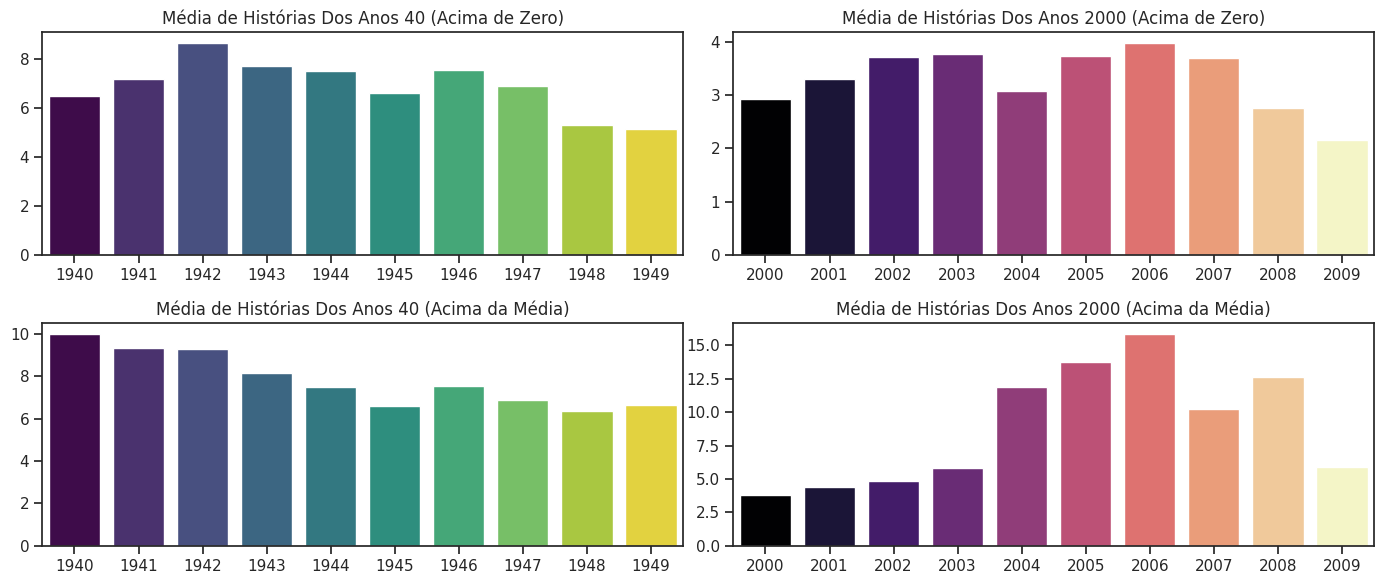

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(14, 6))
# ROW 0
sns.barplot(data=media_historias_zero[(media_historias_zero["onsale_year"] >=1940) & (media_historias_zero["onsale_year"] <= 1949)], x='onsale_year', y='stories.available', palette='viridis', hue="onsale_year", ax=axes[0][0])
axes[0][0].set_title("Média de Histórias Dos Anos 40 (Acima de Zero)")
axes[0][0].legend_.remove()
axes[0][0].set_xlabel("")
axes[0][0].set_ylabel("")

sns.barplot(data=media_historias_zero[(media_historias_zero["onsale_year"] >=2000) & (media_historias_zero["onsale_year"] <= 2009)], x='onsale_year', y='stories.available', palette='magma', hue="onsale_year", ax=axes[0][1])
axes[0][1].set_title("Média de Histórias Dos Anos 2000 (Acima de Zero)")
axes[0][1].legend_.remove()
axes[0][1].set_xlabel("")
axes[0][1].set_ylabel("")
# ROW 1
sns.barplot(data=media_historias_media[(media_historias_zero["onsale_year"] >=1940) & (media_historias_zero["onsale_year"] <= 1949)], x='onsale_year', y='stories.available', palette='viridis', hue="onsale_year", ax=axes[1][0])
axes[1][0].set_title("Média de Histórias Dos Anos 40 (Acima da Média)")
axes[1][0].legend_.remove()
axes[1][0].set_xlabel("")
axes[1][0].set_ylabel("")

sns.barplot(data=media_historias_media[(media_historias_zero["onsale_year"] >=2000) & (media_historias_zero["onsale_year"] <= 2009)], x='onsale_year', y='stories.available', palette='magma', hue="onsale_year", ax=axes[1][1])
axes[1][1].set_title("Média de Histórias Dos Anos 2000 (Acima da Média)")
axes[1][1].legend_.remove()
axes[1][1].set_xlabel("")
axes[1][1].set_ylabel("")

plt.tight_layout()
plt.show()

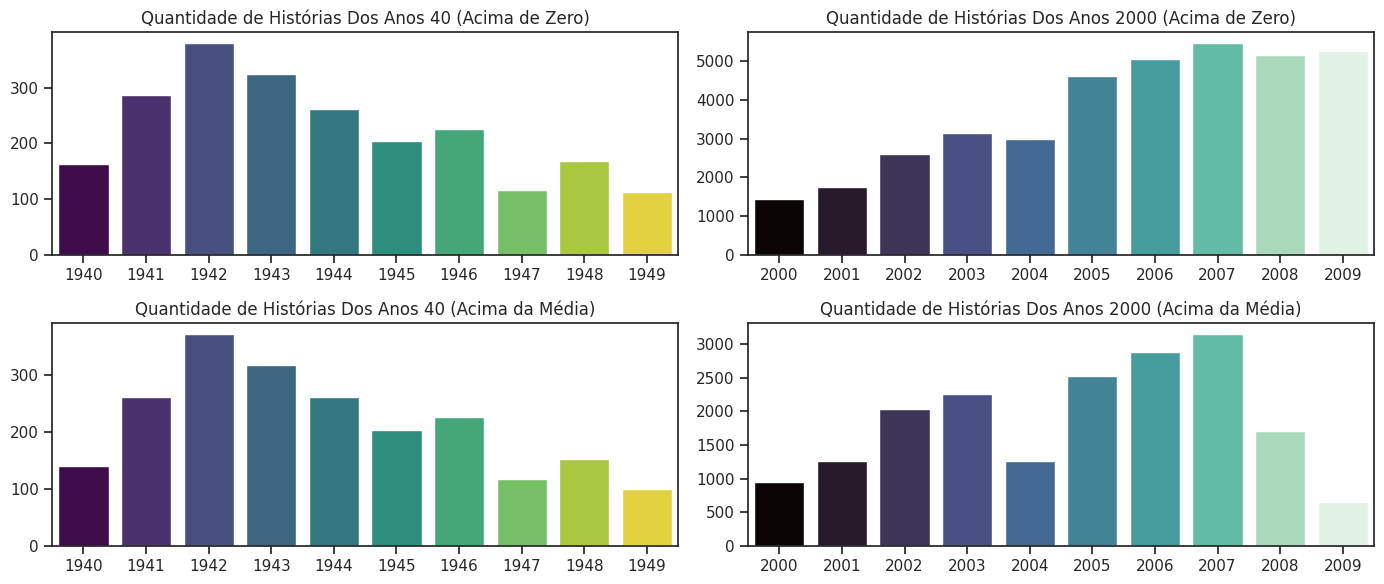

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(14, 6))
# ROW 0
sns.barplot(data=soma_historias_zero[(soma_historias_zero["onsale_year"] >=1940) & (soma_historias_zero["onsale_year"] <= 1949)], x='onsale_year', y='stories.available', palette='viridis', hue="onsale_year", ax=axes[0][0])
axes[0][0].set_title("Quantidade de Histórias Dos Anos 40 (Acima de Zero)")
axes[0][0].legend_.remove()
axes[0][0].set_xlabel("")
axes[0][0].set_ylabel("")

sns.barplot(data=soma_historias_zero[(soma_historias_zero["onsale_year"] >=2000) & (soma_historias_zero["onsale_year"] <= 2009)], x='onsale_year', y='stories.available', palette='mako', hue="onsale_year", ax=axes[0][1])
axes[0][1].set_title("Quantidade de Histórias Dos Anos 2000 (Acima de Zero)")
axes[0][1].legend_.remove()
axes[0][1].set_xlabel("")
axes[0][1].set_ylabel("")
# ROW 1
sns.barplot(data=soma_historias_media[(soma_historias_media["onsale_year"] >=1940) & (soma_historias_media["onsale_year"] <= 1949)], x='onsale_year', y='stories.available', palette='viridis', hue="onsale_year", ax=axes[1][0])
axes[1][0].set_title("Quantidade de Histórias Dos Anos 40 (Acima da Média)")
axes[1][0].legend_.remove()
axes[1][0].set_xlabel("")
axes[1][0].set_ylabel("")

sns.barplot(data=soma_historias_media[(soma_historias_media["onsale_year"] >=2000) & (soma_historias_media["onsale_year"] <= 2009)], x='onsale_year', y='stories.available', palette='mako', hue="onsale_year", ax=axes[1][1])
axes[1][1].set_title("Quantidade de Histórias Dos Anos 2000 (Acima da Média)")
axes[1][1].legend_.remove()
axes[1][1].set_xlabel("")
axes[1][1].set_ylabel("")

plt.tight_layout()
plt.show()

## Relacionamento Criadores, Eventos e Histórias

In [24]:
creators = creators[~creators["fullName"].isna()]
cols = ["fullName", "comics.available", "events.available", "stories.available"]
most_events = creators[cols].sort_values("events.available", ascending=False).head(25)
most_events.head(7)

,fullName,comics.available,events.available,stories.available
855,Vc Joe Caramagna,6823,29,12553
1993,Scott Hanna,1178,21,2051
1261,Frank D'ARMATA,1453,21,2680
1578,Vc Chris Eliopoulos,1427,19,2435
3326,Tom Palmer,859,19,1176
3793,John Romita Jr.,1160,18,2012
1300,Peter David,1289,18,1718


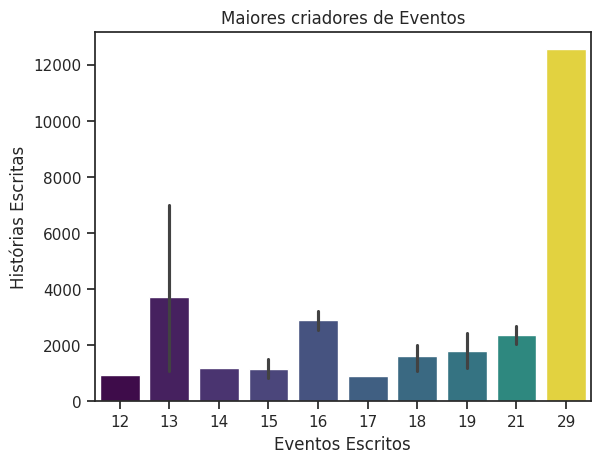

In [25]:
ax = sns.barplot(data=most_events, x="events.available", y="stories.available", hue="events.available", palette="viridis")
ax.legend_.remove()
plt.xlabel("Eventos Escritos")
plt.ylabel("Histórias Escritas")
plt.title("Maiores criadores de Eventos")
plt.show()

In [26]:
cols = ["id", "fullName", "comics.available", "stories.available", "events.available"]
most_stories = creators[cols].sort_values("stories.available", ascending=False).head(25)
most_stories.head(7)

,id,fullName,comics.available,stories.available,events.available
4878,4430,Jeff Youngquist,5405,17934,8
855,5251,Vc Joe Caramagna,6823,12553,29
626,2133,Tom Brevoort,2641,9907,13
3341,4600,Mark Paniccia,2104,8917,10
1189,10172,Vc Clayton Cowles,4099,8910,11
2909,4300,Nick Lowe,1960,7630,13
3806,12974,Vc Joe Sabino,2885,5501,5


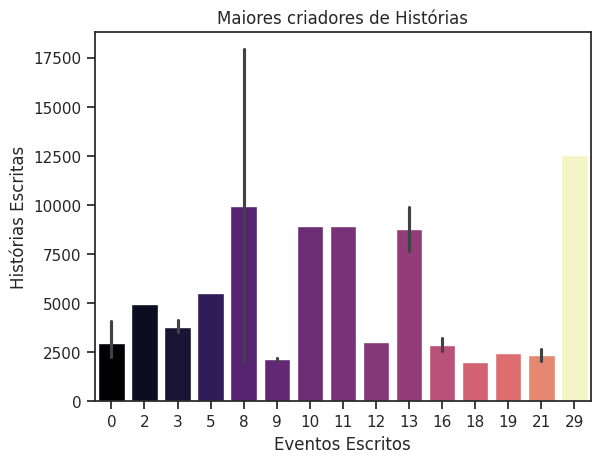

In [28]:
sns.barplot(data=most_stories, x="events.available", y="stories.available", palette="magma", hue="events.available", legend=False)
plt.xlabel("Eventos Escritos")
plt.ylabel("Histórias Escritas")
plt.title("Maiores criadores de Histórias")
plt.show()

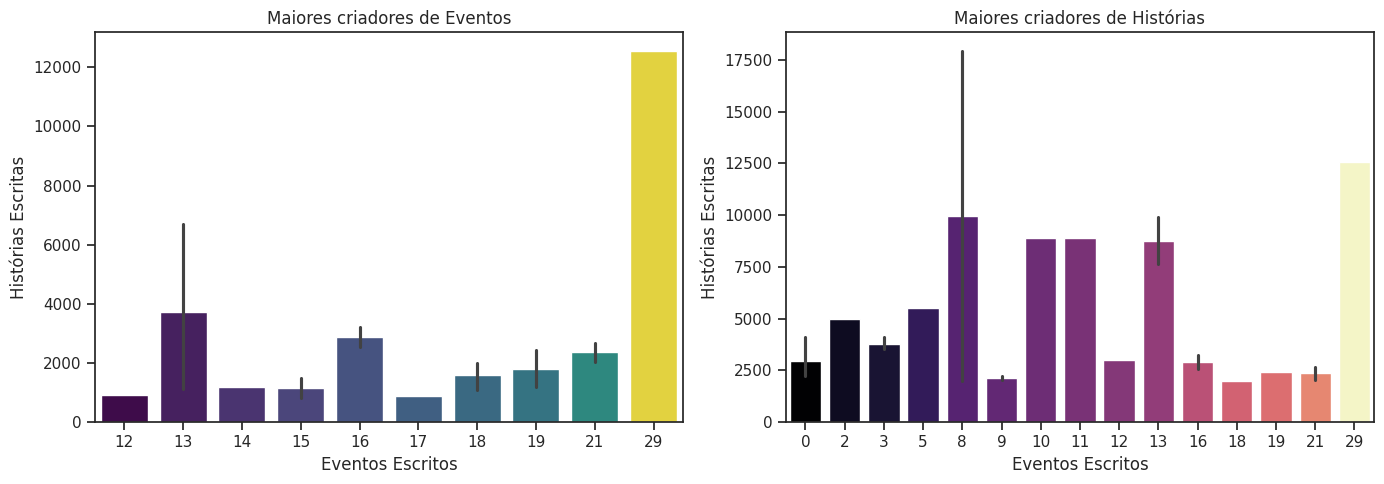

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

sns.barplot(data=most_events, x="events.available", y="stories.available", palette='viridis', ax=axes[0],  legend=False, hue="events.available")
axes[0].set_title("Maiores criadores de Eventos")
axes[0].set_xlabel("Eventos Escritos")
axes[0].set_ylabel("Histórias Escritas")

sns.barplot(data=most_stories, x="events.available", y="stories.available", palette="magma", ax=axes[1],  legend=False, hue="events.available")
axes[1].set_title("Maiores criadores de Histórias")
axes[1].set_xlabel("Eventos Escritos")
axes[1].set_ylabel("Histórias Escritas")

plt.tight_layout()
plt.show()

In [30]:
stories_index = most_stories.index
events_index = most_events.index
combined = []
for author in stories_index:
  if author in events_index:
    combined.append(author)
len(combined)

9

In [31]:
most_stories.loc[combined]

,id,fullName,comics.available,stories.available,events.available
855,5251,Vc Joe Caramagna,6823,12553,29
626,2133,Tom Brevoort,2641,9907,13
2909,4300,Nick Lowe,1960,7630,13
4109,350,Richard Starkings,2636,3231,16
1261,8504,Frank D'ARMATA,1453,2680,21
415,24,Brian Michael Bendis,1826,2551,16
1578,12581,Vc Chris Eliopoulos,1427,2435,19
1993,362,Scott Hanna,1178,2051,21
3793,13196,John Romita Jr.,1160,2012,18


<ipython-input-50-e3a9a18fd1d8>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




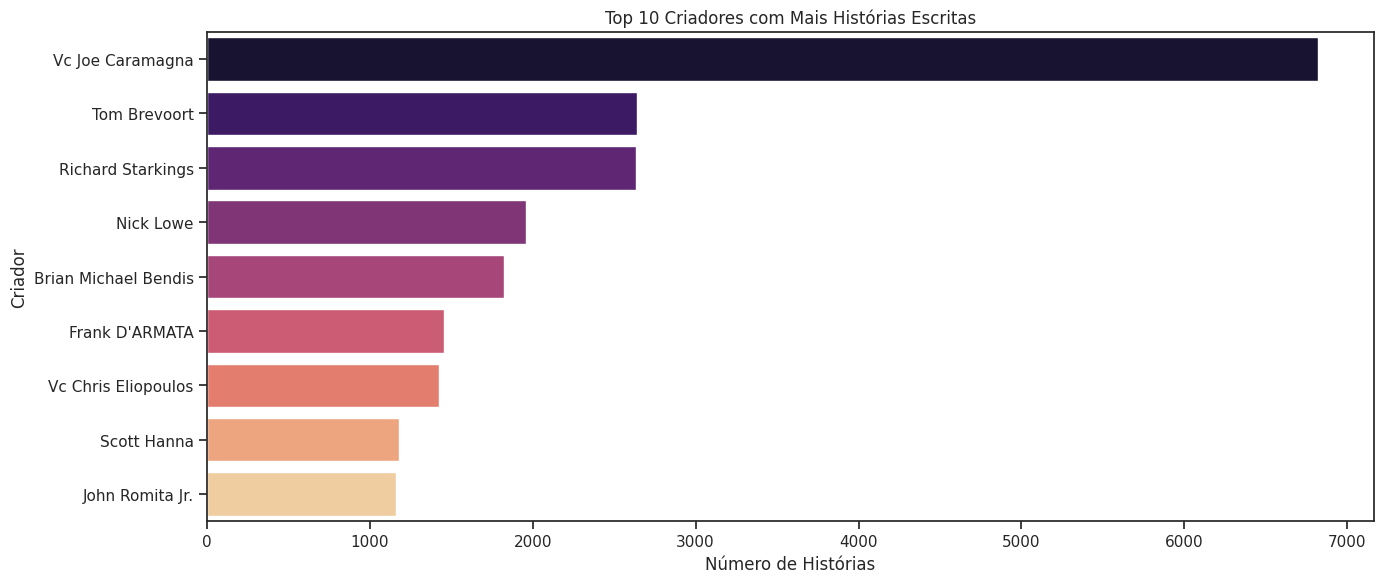

In [50]:
most_stories_sorted = most_stories.loc[combined].sort_values(by="comics.available", ascending=False)

plt.figure(figsize=(14,6))
sns.barplot(data=most_stories_sorted, y='fullName', x='comics.available', palette='magma')
plt.title('Top 10 Criadores com Mais Histórias Escritas')
plt.xlabel('Número de Histórias')
plt.ylabel('Criador')
plt.tight_layout()
plt.show()


In [33]:
creators_rel_events["events_literal_id"] = creators_rel_events["events_ids"].apply(ast.literal_eval)

common = set(creators_rel_events["events_literal_id"][0]) & set(creators_rel_events["events_literal_id"][1]) & set(creators_rel_events["events_literal_id"][2]) & set(creators_rel_events["events_literal_id"][3]) & set(creators_rel_events["events_literal_id"][4])
common = list(common)

common_events = events[events["id"].isin(common)]

common_events[["title", "description", "Ano_Inicio", "Ano_Final"]]

,title,description,Ano_Inicio,Ano_Final
18,Dark Reign,Norman Osborn came out the hero of Secret Inva...,2008,2009
35,Initiative,"After the partial destruction of Stamford, CT,...",2007,2010
53,Secret Invasion,The shape-shifting Skrulls have been infiltrat...,2008,2009


## Relacionamento Eventos Temporalmente

In [34]:
len_start = len(events[events["start"].isna()])
len_end = len(events[events["end"].isna()])

print(f"Quantidade de valores nulos na data de início: {len_start}")
print(f"Quantidade de valores nulos na data de fim: {len_end}")
print(f"Total de linhas: {len(events)}")

Quantidade de valores nulos na data de início: 0
Quantidade de valores nulos na data de fim: 0
Total de linhas: 64


In [35]:
events[["title", "description", "duracao", "comics.available"]].sort_values(by="duracao", ascending=False)

,title,description,duracao,comics.available
38,Kraven's Last Hunt,Frustrated with his repeated failed attempts a...,25,9
56,Secret Wars II,The omnipotent Beyonder comes to Earth to bett...,24,41
45,Mutant Massacre,The underground community of mutants known as ...,24,13
54,Secret Wars,The most powerful heroes and villains in the M...,24,41
7,Armor Wars,Tony Stark discovers that someone has been ste...,23,12
...,...,...,...,...
61,Spider-Island,"This summer, heroes, villains and ordinary peo...",0,29
68,X-Men: Battle of the Atom,The presence of the original X-Men in the mode...,0,10
65,War of Kings,In an effort to punish the Skrulls for their a...,0,43
70,X-Men: Schism,A new Hellfire Club unleashes Sentinels on Uto...,0,11


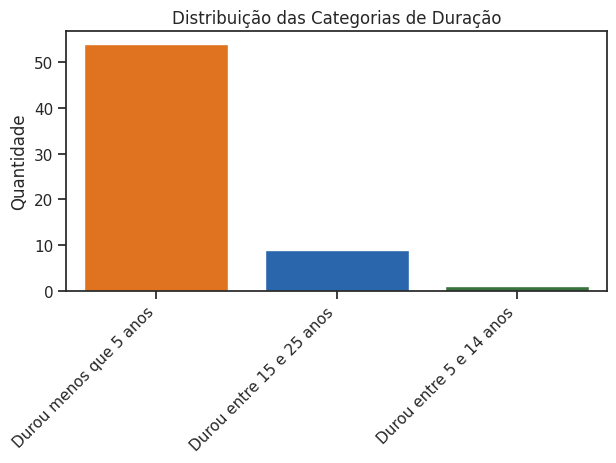

In [36]:
ordered_categories = events['categoria_duracao'].value_counts().index.tolist()

custom_colors = {
    "Durou menos que 5 anos": "#FF6F00",
    "Durou entre 5 e 14 anos": "#2E7D32",
    "Durou entre 15 e 25 anos": "#1565C0",
}

sns.countplot(
    data=events,
    x='categoria_duracao',
    hue="categoria_duracao",
    order=ordered_categories,
    palette=custom_colors
)

plt.ylabel("Quantidade")
plt.xlabel("")
plt.title("Distribuição das Categorias de Duração")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

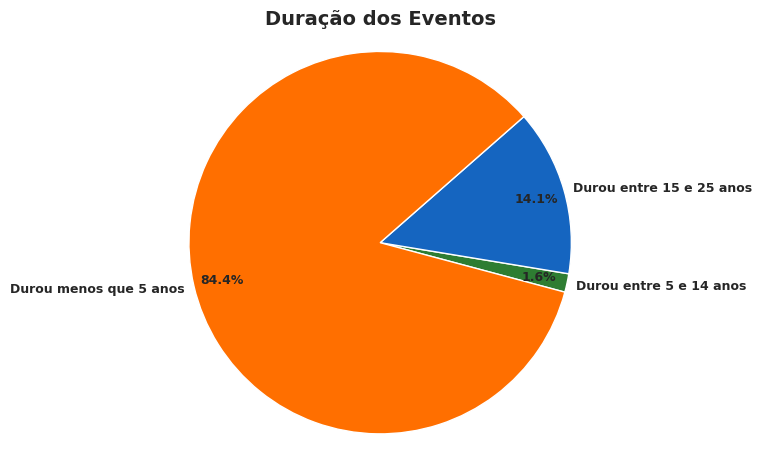

In [87]:
counts = events['categoria_duracao'].value_counts()

# Ordena do maior para o menor
counts = counts.sort_values(ascending=True)

labels = counts.index
sizes = counts.values
colors = [custom_colors[label] for label in labels]

fig, ax = plt.subplots()

ax.pie(
    sizes,
    labels=labels,
    colors=colors,
    startangle=-15,
    autopct='%1.1f%%',
    pctdistance=0.85,
    labeldistance=1.05,
    textprops={'fontsize': 9, 'fontweight':'bold'}
)

ax.axis('equal')

plt.title("Duração dos Eventos", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [38]:
events[events["categoria_duracao"] == "Durou entre 5 e 14 anos"][["title", "description", "Ano_Inicio", "duracao"]]

,title,description,Ano_Inicio,duracao
31,Infinity Gauntlet,"When the Mad Titan, Thanos, acquires the all-p...",1991,14


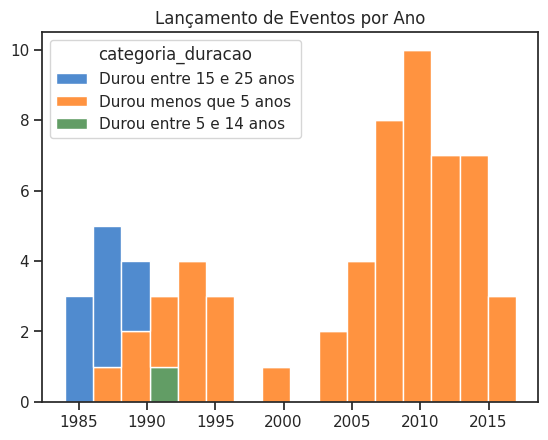

In [39]:
sns.histplot(data=events[events["Ano_Inicio"] <= 2025], x="Ano_Inicio", binwidth=2, hue="categoria_duracao", multiple="stack", palette=custom_colors)
plt.title("Lançamento de Eventos por Ano")
plt.xlabel("")
plt.ylabel("")
plt.show()

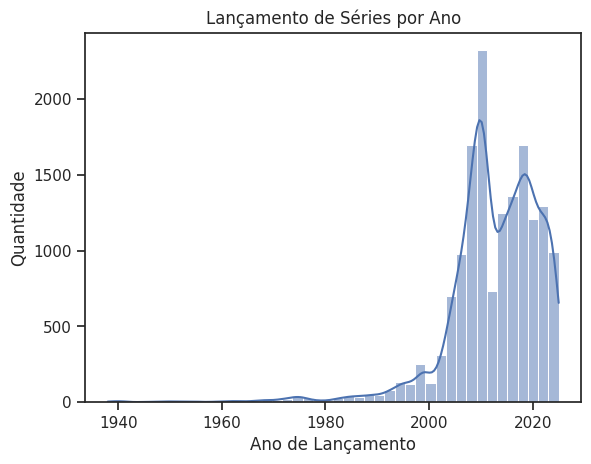

In [40]:
sns.histplot(data=series[(series["startYear"] > 1900) & (series["startYear"] <= 2025)], x="startYear", kde=True, binwidth=2)
plt.title("Lançamento de Séries por Ano")
plt.xlabel("Ano de Lançamento")
plt.ylabel("Quantidade")
plt.show()

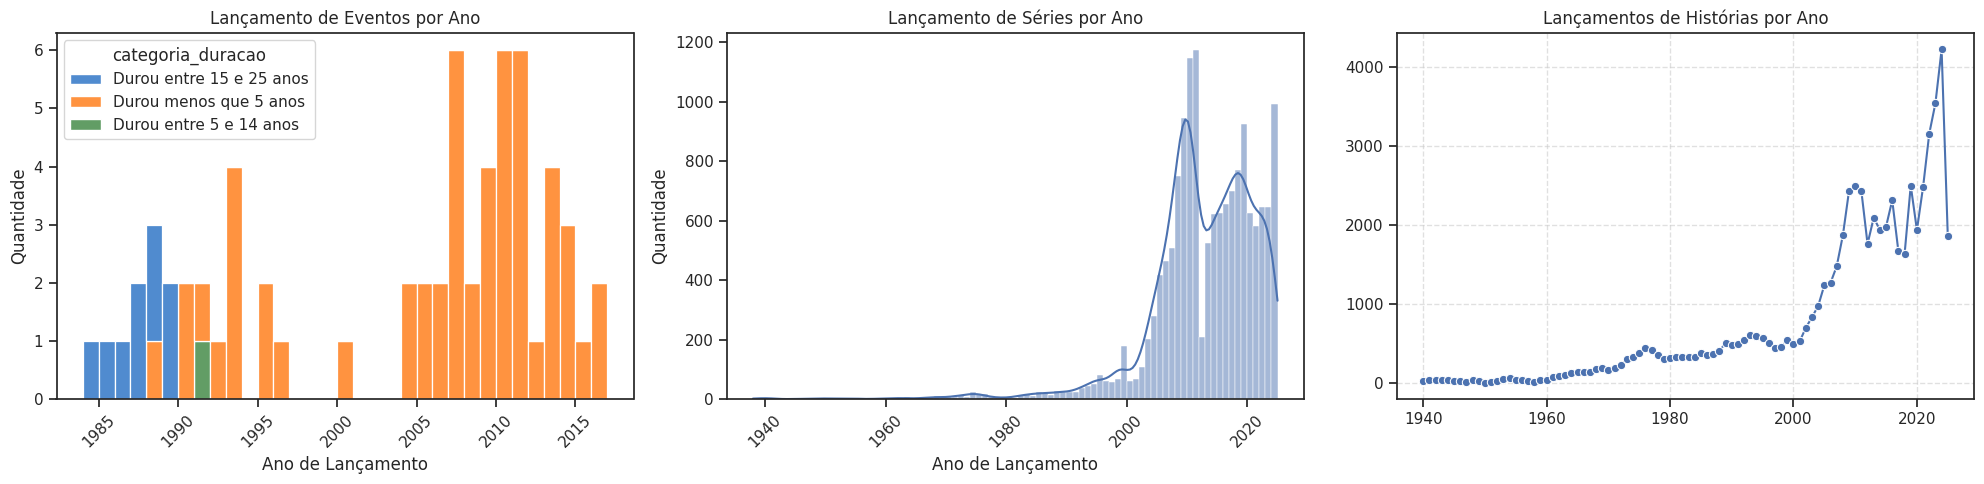

In [89]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))  # 1 row, 2 columns

sns.histplot(data=events[(events["Ano_Inicio"] <= 2025) & (events["Ano_Inicio"] >= 1900)], x="Ano_Inicio", binwidth=1, hue="categoria_duracao", multiple="stack", ax = axes[0], palette=custom_colors)
axes[0].set_title("Lançamento de Eventos por Ano")
axes[0].set_xlabel("Ano de Lançamento")
axes[0].set_ylabel("Quantidade")
axes[0].tick_params(axis='x', rotation=45)

#sns.histplot(data=series[(series["startYear"] >= 2010) & (series["startYear"] <= 2025)], x="startYear", kde=True, binwidth=1, ax=axes[1])
sns.histplot(data=series[(series["startYear"] >= 1900) & (series["startYear"] <= 2025)], x="startYear", kde=True, binwidth=1, ax=axes[1])
axes[1].set_title("Lançamento de Séries por Ano")
axes[1].set_xlabel("Ano de Lançamento")
axes[1].set_ylabel("Quantidade")
axes[1].tick_params(axis='x', rotation=45)

launches_per_year = comics.groupby('onsale_year').size().reset_index(name='Quantidade')
sns.lineplot(data=launches_per_year, x='onsale_year', y='Quantidade', marker='o', color='b', ax=axes[2])
axes[2].set_title('Lançamentos de Histórias por Ano')
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].grid(True, linestyle='--', alpha=0.6)


plt.tight_layout()
plt.show()

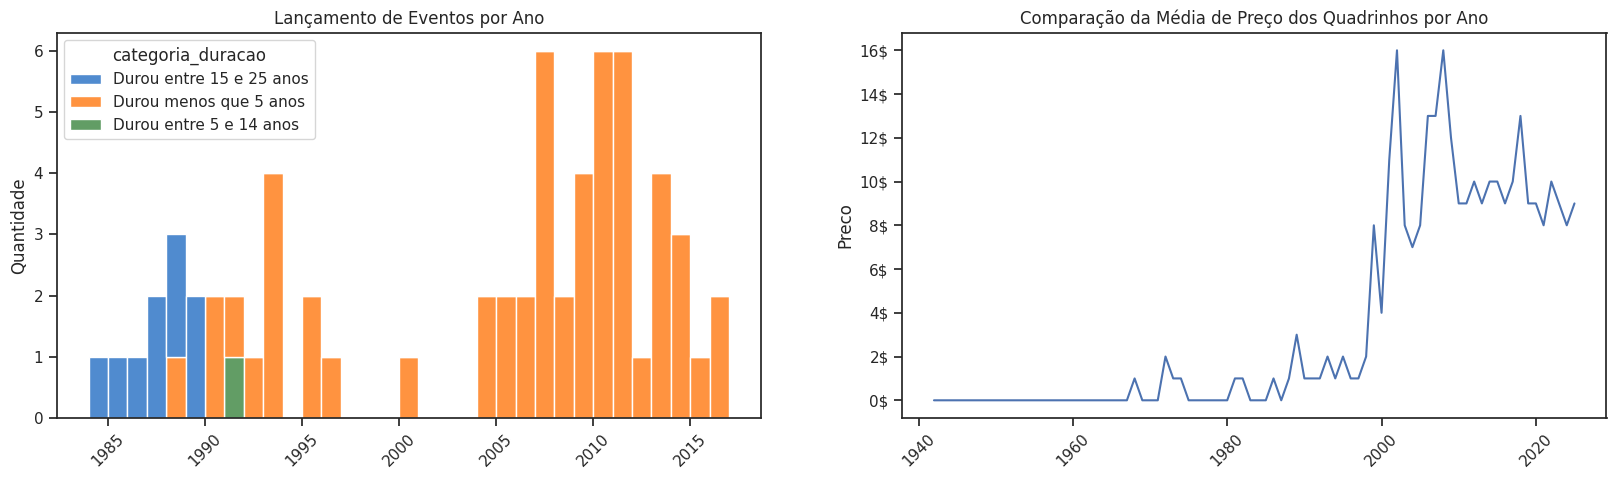

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))  # 1 row, 2 columns

sns.histplot(data=events[(events["Ano_Inicio"] <= 2025) & (events["Ano_Inicio"] >= 1900)], x="Ano_Inicio", binwidth=1, hue="categoria_duracao", multiple="stack", ax = axes[0], palette=custom_colors)
axes[0].set_title("Lançamento de Eventos por Ano")
axes[0].set_xlabel("")
axes[0].set_ylabel("Quantidade")
axes[0].tick_params(axis='x', rotation=45)

sns.lineplot(data=media_precos_maior_zero, x='Ano', y='Preco', markers=True, dashes=False)
axes[1].set_title("Comparação da Média de Preço dos Quadrinhos por Ano")
axes[1].set_xlabel("")
axes[1].tick_params(axis='x', rotation=45)
formatter = FuncFormatter(lambda x, pos: f'{x:.0f}$')
axes[1].yaxis.set_major_formatter(formatter)

In [42]:
traducao_formatos = {
    'Catalog': 'Catálogo',
    'Comic': 'Quadrinho',
    'Digest': 'Formato Digest',
    'Digital collection': 'Coleção Digital',
    'Digital comic': 'Quadrinho Digital',
    'Digital vertical comic': 'Quadrinho Digital Vertical',
    'Graphic novel': 'Graphic Novel',
    'Hardcover': 'Capa Dura',
    'Hardcover book': 'Livro de Capa Dura',
    'Infinite comic': 'Quadrinho Infinito',
    'Magazine': 'Revista',
    'Newspaper': 'Jornal',
    'Poster': 'Pôster',
    'Sketchbook': 'Sketchbook',
    'Trade paperback': 'Encadernado'
}

In [43]:
custom_palette = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"
]

comics["format_traduzido"] = comics["format"].map(traducao_formatos).fillna(comics["format"])

formato_por_ano = comics.groupby(["onsale_year", "format_traduzido"]).size().reset_index(name="Quantidade")


fig = px.area(
    formato_por_ano,
    x="onsale_year",
    y="Quantidade",
    color="format_traduzido",
    title="Evolução dos Lançamentos por Formato (Ano de Lançamento)",
    labels={"onsale_year": "Ano", "Quantidade": "Número de Lançamentos", "format_traduzido": "Formato"},
    color_discrete_sequence=custom_palette
)

fig.update_layout(
    template="plotly_white",
    yaxis=dict(title="Número de Lançamentos"),
    legend=dict(title="Formato"),
    height=600
)

fig.show()


In [44]:
events[(events["Ano_Inicio"] >= 2010) & (events["Ano_Inicio"] <= 2020)][["title", "description", "duracao", "Ano_Inicio", "Ano_Final"]].reset_index(drop=True)

,title,description,duracao,Ano_Inicio,Ano_Final
0,Age of Ultron,In a 10-issue event written by Brian Michael B...,0,2013,2013
1,Age of X,In a strange reality where the X-Men never cam...,0,2011,2011
2,Avengers VS X-Men,A 12-issue event written by the unprecedented ...,0,2012,2012
3,Axis,The Red Skull has taken over Genosha and stand...,0,2014,2014
4,Chaos War,When the Chaos King embarks on a campaign to w...,1,2010,2011
5,Dead No More: The Clone Conspiracy,The Jackal has returned and initiated the Clon...,1,2016,2017
6,Fear Itself,"The Serpent, God of Fear and brother to the Al...",0,2011,2011
7,Heroic Age,Still lurking in the shadows are forces of evi...,2,2010,2012
8,Infinity,While the most powerful Avengers journey into ...,0,2013,2013
9,Inhumanity,"Following Infinity, the actions of Black Bolt ...",1,2013,2014


In [53]:
events[(events["Ano_Inicio"] >= 1985) & (events["Ano_Inicio"] <= 1995)][["title", "description", "duracao", "Ano_Inicio", "Ano_Final"]].reset_index(drop=True)

,title,description,duracao,Ano_Inicio,Ano_Final
0,Acts of Vengeance!,Loki sets about convincing the super-villains ...,19,1989,2008
1,Age of Apocalypse,"In a twisted version of the world they knew, t...",1,1995,1996
2,Armor Wars,Tony Stark discovers that someone has been ste...,23,1987,2010
3,Atlantis Attacks,Ghaur returns to complete his quest to resurre...,22,1989,2011
4,Blood and Thunder,Driven mad by the machinations of the evil Val...,1,1993,1994
5,Crossing,Iron Man betrays the Avengers to Kang at the c...,1,1995,1996
6,Days of Future Present,An adult Franklin Richards travels back from t...,0,1990,1990
7,Evolutionary War,The High Evolutionary intends to help humanity...,0,1988,1988
8,Fall of the Mutants,"The X-Men battled the Adversary in Dallas, and...",19,1988,2007
9,Fatal Attractions,"Magneto returns, more powerful than ever, and ...",0,1993,1993


In [46]:
top_series = series.sort_values(by="comics.available", ascending=False).head(10)

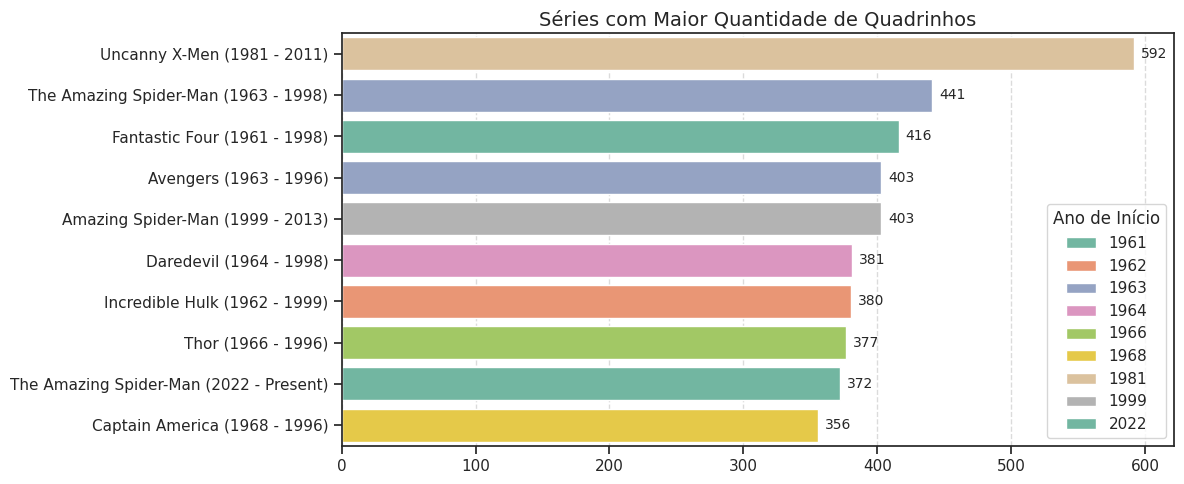

In [47]:
top_series_sorted = top_series.sort_values(by="comics.available", ascending=False)

plt.figure(figsize=(12, 5))
ax = sns.barplot(
    data=top_series_sorted,
    x="comics.available",
    y="title",
    hue="startYear",
    palette="Set2",
)

for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=5, fontsize=10)

plt.xlabel("")
plt.ylabel("")
plt.title("Séries com Maior Quantidade de Quadrinhos", fontsize=14)
plt.legend(title="Ano de Início")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
events_em_comum = events[events["id"].isin(common)]
events_em_comum[["title", "description", "Ano_Inicio", "Ano_Final"]]
